# 0. Background Information

**Data Sources**: https://www.gov.uk/school-performance-tables

- [Attainment 8 and Progress 8 explained](https://www.locrating.com/Blog/attainment-8-and-progress-8-explained.aspx)
- [Progress 8 and Attainment 8 explained](https://www.goodschoolsguide.co.uk/curricula-and-exams/progress-8-attainment-8)





**Reference papers**: 

- https://www.cambridgeassessment.org.uk/Images/505041-how-have-students-and-schools-performed-on-the-progress-8-performance-measure-.pdf




# 1. Setup the Environment

In [1]:
MYLIBRARIES<-c("outliers",
               "corrplot",
               "formattable",
               "stats",
               "caret",
               "PerformanceAnalytics",
               "stringr",
               "partykit",
               "C50",
               "randomForest",
               "keras",
               "h2o"
                )


gc() # garbage collection to automatically release memory

# clear plots and other graphics
if(!is.null(dev.list())) dev.off()
graphics.off()

# This clears all warning messages
#assign("last.warning", NULL, envir = baseenv())

# clears the console area
cat("\014")

# Please update your path of working dir
setwd("C:\\Users\\AK\\Desktop\\School Data\\Extracted")

print("START Supervised Machine Learning")

library(pacman)
pacman::p_load(char=MYLIBRARIES,install=TRUE,character.only=TRUE)


set.seed(123)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,616467,33.0,1308005,69.9,1308005,69.9
Vcells,1103859,8.5,8388608,64.0,1663099,12.7


null device 
          1

[1] "START Supervised Machine Learning"


In [4]:
TYPE_DISCRETE     <- "DISCRETE"           # field is discrete (numeric)
TYPE_ORDINAL      <- "ORDINAL"            # field is continuous numeric
TYPE_SYMBOLIC     <- "SYMBOLIC"           # field is a string
TYPE_NUMERIC      <- "NUMERIC"            # field is initially a numeric
TYPE_IGNORE       <- "IGNORE"             # field is not encoded

DISCRETE_BINS     <- 6                    # Number of empty bins to determine discrete
MAX_LITERALS      <- 55                   # Maximum numner of hotcoding new fields


# provided functions 
# ************************************************
# This work is licensed under a Creative Commons
# Attribution-NonCommercial 4.0 International License.
# ************************************************
#
# Prof. Nick F Ryman-Tubb
# Dr Spencer Thomas
# Department of Computer Science
# University of Surrey
# GUILDFORD
# Surrey GU2 7XH
#
# UPDATE
# 1.00      1/2/2017    Initial Version
# 1.10      24/2/2019   Only code for rule output now inlcuded
# 1.11      8/8/2018    N_DEEP_TrainClassifier(), N_DEEP_Initialise reproducable parameter for h2o learning
# 1.12      27/9/2019   N_DEEP_Initialise() reproducable is optional parameter
# 1.13      22/10/2019  Added NROCgraph() which is modified myPerformancePlot() from lab3.R
# 1.14                  Created NdetermineThreshold()
#                       NDT5RuleOutput() now outputs class label as BAD or GOOD loan
# 1.15      27/10/2019  Added NConvertClass() top reduce clutter in lab code
# 1.16      31/10/2019  NdetermineThrehold(), added axis bound checks in abline plots
# 1.17      29/5/2020   NdetermineThreshold() added quiet parameter & use mindist as threshold
# 1.18      19/10/2020  NdetermineThreshold() use won ROC chart, as lab 3
# 1.19      20/10/2020  Added auroc() to calculate AUC for the ROC chart
#                       N_EVALUATE_DeepNeural() update for vector of expected values
# 1.20      11/11/2020  N_DEEP_Initialise() remove "max_mem_size=" that prevents H2O from using more than that amount of memory
# 1.21      16/3/2021   NplotTree() added new function to output tree
# 1.22      10/09/2022  updeted for jupyter
# ************************************************
print("Loaded 4LabFunctions.R Version 1.20")

# ************************************************
# NplotTree() :
#
# Plots tree to a PDF file
#
# INPUT   :
#             Data Frame    - train - to create the DT
#             int           - boost - optional parameter
#
# OUTPUT  :
#             File is created
#
# ************************************************
NplotTree<-function(train,boost=1){

  positionClassOutput<-which(names(train)==OUTPUT_FIELD)

  # Due to an issue with the R library, the dataset
  # has to be at the global environment level

  # train data: dataframe with the input fields
  Global_train_inputs<<-train[,-positionClassOutput]

  # train data: vector with the expedcted output
  Global_train_expected<<-train[,positionClassOutput]

    tree<-C50::C5.0(x=Global_train_inputs,
                  factor(Global_train_expected),
                  rules=FALSE,
                  trials=boost)

    # ::: is used to directly access a member of a package that is internal
    suppressWarnings(graphtree<-C50:::as.party.C5.0(tree))

    # The plot is large - so print to a big PDF file
    pdf(PDF_FILENAME, width=100, height=50, paper="special", onefile=F)

    # The number is the node level of the tree to print
    plot(graphtree[NODE_LEVEL])

    #This closes the PDF file
    dev.off()

    # Remove the global level objects
    rm(Global_train_inputs,pos=1)
    rm(Global_train_expected,pos=1)
}

# ************************************************
# NConvertClass() :
#
# In original dataset, $Status is the classification label
# We need to convert this to give the minority class a value of 0
# this just makes it easiert to define the confusioon matrix!
# for the UCI-G this is a class of {0,1} being {bad, good}
#
# INPUT   :
#             Data Frame        - dataset
#
# OUTPUT  :
#             Data Frame        - dataset
#
# ************************************************
NConvertClass<-function(dataset){
  positionClassOutput<-which(names(dataset)==OUTPUT_FIELD)
  classes<-sort(table(dataset[,positionClassOutput])) #smallest class will be first
  minority<-names(classes[1])
  indexToStatus2<-which(dataset[positionClassOutput]==minority)
  dataset[positionClassOutput][indexToStatus2,]<-0
  dataset[positionClassOutput][-indexToStatus2,]<-1
  return(dataset)
}

# ************************************************
# NEvaluateClassifier() :
#
# Use dataset to generate predictions from model
# Evaluate as classifier using threshold value
#
# INPUT   :   vector double     - probs        - probability of being class 1
#             Data Frame        - testing_data - Dataset to evaluate
#             double            - threshold     -cutoff (probability) for classification
#
# OUTPUT  :   List       - Named evaluation measures
#                        - Predicted class probability
#
# ************************************************
NEvaluateClassifier<-function(test_predicted,test_expected,threshold) {

  predictedClass<-ifelse(test_predicted<threshold,0,1)

  results<-NcalcConfusion(expectedClass=test_expected,
                          predictedClass=predictedClass)

  return(results)
} #endof NEvaluateClassifier()


# ************************************************
# Nauroc() :
#
# Calculate the Area Under Curve (AUC) for ROC
#
# INPUT   :   vector double     - score            - probability of being class 1
#             vector double     - bool             - Expected class of 0 or 1
#
# OUTPUT  :   double   - AUC
#
# ************************************************
# By Miron Kursa https://mbq.me
# See https://stackoverflow.com/questions/4903092/calculate-auc-in-r

auroc <- function(score, bool) {
  n1 <- sum(!bool)
  n2 <- sum(bool)
  U  <- sum(rank(score)[!bool]) - n1 * (n1 + 1) / 2
  return(1 - U / n1 / n2)
}

# ************************************************
# NdetermineThreshold() :
#
# For the range of threholds [0,1] calculate a confusion matrix
# and classifier metrics.
# Deterime "best" threshold based on either distance or Youdan
# Plot threshold chart and ROC chart
#
# Plot the results
#
# INPUT   :   vector double  - test_predicted   - probability of being class 1
#         :   vector double  - test_expected    - dataset to evaluate
#         :   boolean        - plot             - TRUE=output charts
#         :   string         - title            - chart title
#
# OUTPUT  :   List       - Named evaluation measures from confusion matrix
#                        - Threshold at min Euclidean distance
#                        - AUC - area under the ROC curve
#                        - Predicted class probability
#
# 241019NRT - added plot flag and title for charts
# 311019NRT - added axis bound checks in abline plots
# 191020NRT - Updated to use own ROC plot & calculate AUC
# ************************************************
NdetermineThreshold<-function(test_predicted,
                              test_expected,
                              plot=TRUE,
                              title=""){
  toPlot<-data.frame()

  #Vary the threshold
  for(threshold in seq(0,1,by=0.01)){
    results<-NEvaluateClassifier(test_predicted=test_predicted,
                                  test_expected=test_expected,
                                  threshold=threshold)
    toPlot<-rbind(toPlot,data.frame(x=threshold,fpr=results$FPR,tpr=results$TPR))
  }

  # the Youden index is the vertical distance between the 45 degree line
  # and the point on the ROC curve.
  # Higher values of the Youden index are better than lower values.
  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5082211/
  # Youdan = sensitivty + specificity -1
  #        = TPR + (1-FPR) -1

  toPlot$youdan<-toPlot$tpr+(1-toPlot$fpr)-1

  # 121020NRT - max Youdan
  # use which.max() to return a single index to the higest value in the vector
  maxYoudan<-toPlot$x[which.max(toPlot$youdan)]

  # Euclidean distance sqrt((1 − sensitivity)^2+ (1 − specificity)^2)
  # To the top left (i.e. perfect classifier)
  toPlot$distance<-sqrt(((100-toPlot$tpr)^2)+((toPlot$fpr)^2))

  # 121020NRT - Euclidean distance to "perfect" classifier (smallest the best)
  # use which.min() to return a single index to the lowest value in the vector
  minEuclidean<-toPlot$x[which.min(toPlot$distance)]

  # ************************************************
  # Plot threshold graph

  if (plot==TRUE){
    # Sensitivity (TPR)
    plot(toPlot$x,toPlot$tpr,
         xlim=c(0, 1), ylim=c(0, 100),
         type="l",lwd=3, col="blue",
         xlab="Threshold",
         ylab="%Rate",
         main=paste("Threshold Perfomance Classifier Model",title))

    # Plot the specificity (1-FPR)
    lines(toPlot$x,100-toPlot$fpr,type="l",col="red",lwd=3,lty=1)

    # The point where specificity and sensitivity are the same
    crosspoint<-toPlot$x[which(toPlot$tpr<(100-toPlot$fpr))[1]]

    if (!is.na(crosspoint)){
      if ((crosspoint<1) & (crosspoint>0))
        abline(v=crosspoint,col="red",lty=3,lwd=2)
    }

    # Plot the Euclidean distance to "perfect" classifier (smallest the best)
    lines(toPlot$x,toPlot$distance,type="l",col="green",lwd=2,lty=3)

    # Plot the min distance, as might be more (311019NRT check it is within range)
    if ((minEuclidean<1) & (minEuclidean>0))
      abline(v=minEuclidean,col="green",lty=3,lwd=2)

    # Youdan (Vertical distance between the 45 degree line and the point on the ROC curve )
    lines(toPlot$x,toPlot$youdan,type="l",col="purple",lwd=2,lty=3)

    if ((maxYoudan<1) & (maxYoudan>0))
      abline(v=maxYoudan,col="purple",lty=3,lwd=2)

    legend("bottom",c("TPR","1-FPR","Distance","Youdan"),col=c("blue","red","green","purple"),lty=1:2,lwd=2)
    text(x=0,y=50, adj = c(-0.2,2),cex=1,col="black",paste("THRESHOLDS:\nEuclidean=",minEuclidean,"\nYoudan=",maxYoudan))

    # ************************************************
    # 121020NRT ROC graph

    sensitivityROC<-toPlot$tpr[which.min(toPlot$distance)]
    specificityROC<-100-toPlot$fpr[which.min(toPlot$distance)]
    auc<-auroc(score=test_predicted,bool=test_expected) # Estimate the AUC

    # Set origin point for plotting
    toPlot<-rbind(toPlot,data.frame(x=0,fpr=0,tpr=0, youdan=0,distance=0))

    plot(100-toPlot$fpr,toPlot$tpr,type="l",lwd=3, col="black",
         main=paste("ROC:",title),
         xlab="Specificity (1-FPR) %",
         ylab="Sensitivity (TPR) %",
         xlim=c(100,0),
         ylim=c(0,100)
    )

    axis(1, seq(0.0,100,10))
    axis(2, seq(0.0,100,10))

    #Add crosshairs to the graph
    abline(h=sensitivityROC,col="red",lty=3,lwd=2)
    abline(v=specificityROC,col="red",lty=3,lwd=2)

    annotate<-paste("Threshold: ",round(minEuclidean,digits=4L),
                    "\nTPR: ",round(sensitivityROC,digits=2L),
                    "%\n1-FPR: ",round(specificityROC,digits=2L),
                    "%\nAUC: ",round(auc,digits=2L),sep="")

    text(x=specificityROC, y=sensitivityROC, adj = c(-0.2,1.2),cex=1, col="red",annotate)

  } # endof if plotting

  # Select the threshold - I have choosen distance

  myThreshold<-minEuclidean      # Min Distance should be the same as analysis["threshold"]

  #Use the "best" distance threshold to evaluate classifier
  results<-NEvaluateClassifier(test_predicted=test_predicted,
                                test_expected=test_expected,
                                threshold=myThreshold)

  results$threshold<-myThreshold
  results$AUC<-auroc(score=test_predicted,bool=test_expected) # Estimate the AUC

  return(results)
} #endof myPerformancePlot()

# ************************************************
# NprintDTRules() :
#
# INPUT: text - filename
#
# OUTPUT : Frame - dataset
# ************************************************
NprintDTRules<-function(dtrules, filename){

  sink(filename)

  for (r in 1:nrow(dtrules)){
    print(paste("[",r,"]",dtrules$Rule[r],"==",(ifelse(dtrules$Class[r]==0,"BAD","GOOD"))))
  }
  sink()
}
# ************************************************
# DECISION TREE CONVERT DT RULES TO ASCII FORMATTED RULES
#
# <anticedent 1> AND <anticedent 2> ...
# Each anticedent is: [field][comparision][value]
#
# INPUT: Object - tree - Trained tree
#
# OUTPUT: data frame of rules, class and anticedents
# ************************************************
NDT5RuleOutput<-function(tree){
  #library(stringr)
  x<-summary(tree)[1]
  x<-substr(x,regexpr("Rules:",x)[1]+8,nchar(x))
  x<-substr(x,1,regexpr("Evaluation on training data",x)[1]-1)
  x<-gsub("[\n\t]", "*", x)
  df_of_rules<-data.frame(matrix(ncol=3,nrow=tree$size),stringsAsFactors = FALSE)
  df_of_rules<-setNames(df_of_rules,c("Rule","Class","Anti"))

  numberofrules<-tree$size
  # 271019 allow for multiple trees (i.e. boosted)
  if (length(numberofrules)>1){
    numberofrules<-numberofrules[1]
    warning("More than one tree found. Extracting rules for just the first")
  }

  totalAnticedents<-0
  for (ruleNumber in 1:numberofrules){
    start<-regexpr("\\*\\*",x)[1]+2
    end<-regexpr("->",x)[1]-3
    onerule<-substr(x,start,end) #Single rule, anticedents seperated by '**'
    onerule<-gsub("\\*\\*"," AND ",onerule) #Rule now has "AND" between anticedents
    #onerule<-convertNormalisedDTRuleToRealWorld(onerule)
    NumAnticedents<-str_count(onerule,"AND")+1
    totalAnticedents=totalAnticedents+NumAnticedents
    classpos<-regexpr("class ",x)+6
    classID<-as.numeric(substr(x,classpos,classpos))  #This has the class of the rule, i.e. {0,1}
    df_of_rules$Rule[ruleNumber]<-onerule
    df_of_rules$Class[ruleNumber]<-ifelse(classID==0,"BAD","GOOD") # Convert class to label
    df_of_rules$Anti[ruleNumber]<-NumAnticedents
    x<-substr(x,classpos,nchar(x))
    st<-regexpr("\\*\\*",x)[1]+2 #move past the rule ID
    x<-substr(x,st,nchar(x))
  }
  return(df_of_rules)
}

# ************************************************
# N_DEEP_Initialise()
# Initialise the H2O server
#
# INPUT:
#         Bool       - reproducible       - TRUE if model must be reproducable each run
#
# OUTPUT : none
# ************************************************
N_DEEP_Initialise<-function(reproducible=TRUE){

#  library(h2o)

  print("Initialise the H2O server")
  #Initialise the external h20 deep learning local server if needed
  #130517NRT - set nthreads to -1 to use maximum so fast, but set to 1 to get reproducable results
  #080819NRT - use reproducible parameter
  #111120NRT - remove "max_mem_size=" that prevents H2O from using more than that amount of memory
  if (reproducible==TRUE)
    nthreads<-1
  else
    nthreads<- -1

  h2o.init(nthreads = nthreads)

  h2o.removeAll() # 261019NRT clean slate - just in case the cluster was already running

    #h2o.no_progress()
}

# ************************************************
# N_DEEP_TrainClassifier()
#
# h2O NEURAL NETWORK : DEEP LEARNING CLASSIFIER TRAIN
#
# INPUT:  Frame      - train              - scaled [0.0,1.0], fields & rows
#         String     - fieldNameOutput    - Name of the field to classify
#         Int Vector - hidden             - Number of hidden layer neurons for each layer
#         int        - stopping_rounds    - Number of times no improvement before stop
#         double     - stopping_tolerance - Error threshold
#         String     - activation         - Name of activation function
#         Bool       - reproducible       - TRUE if model must be reproducable each run
#
# OUTPUT: object     - trained neural network
# ************************************************
N_DEEP_TrainClassifier<- function(train,
                                  fieldNameOutput,
                                  hidden,
                                  stopping_rounds,
                                  stopping_tolerance,
                                  activation,
                                  reproducible){

  #positionOutput<-which(names(train)==fieldNameOutput)

  #Creates the h2o training dataset
  train[fieldNameOutput] <- lapply(train[fieldNameOutput] , factor) #Output class has to be a R "factor"

  train_h2o <- as.h2o(train, destination_frame = "traindata")

  # Create validation dataset for early stopping
  splits <- h2o.splitFrame(train_h2o, 0.9, seed=1234)
  nntrain  <- h2o.assign(splits[[1]], "nntrain.hex") # 90%
  nnvalid  <- h2o.assign(splits[[2]], "nnvalid.hex") # 10%

  #This lists all the input field names ignoring the fieldNameOutput
  predictors <- setdiff(names(train_h2o), fieldNameOutput)

  # Deep training neural network
  # Updated 13/5/17 - set reproducible = TRUE so that the same random numbers are used to initalise
  # 281019NRT - added validation dataset for early stopping

  deep<-h2o::h2o.deeplearning(x=predictors,
                              y=fieldNameOutput,
                              training_frame = nntrain,
                              validation_frame=nnvalid,
                              epochs=BASICNN_EPOCHS,
                              hidden=hidden,
                              adaptive_rate=TRUE,
                              stopping_rounds=stopping_rounds,
                              stopping_tolerance=stopping_tolerance,
                              stopping_metric = "misclassification",
                              fast_mode=FALSE,
                              activation=activation,
                              seed=1234,
                              l1 = 1e-2,
                              l2 = 1e-2,
                              variable_importances = TRUE,
                              reproducible = TRUE)
  return(deep)
}

# ************************************************
# N_EVALUATE_DeepNeural() :
#
# Evaluate Deep Neural Network classifier
# Generates probabilities from the classifier
#
# INPUT: Data Frame    -  test             - scaled [0.0,1.0], fields & rows
#        String        -  fieldNameOutput  - Name of the field that we are training on (i.e.Status)
#        Object         - deep             - trained NN including the learn weights, etc.
#         boolean      - plot              - TRUE = output charts/results
#         string       - myTitle           - title on results
#
# OUTPUT :
#         list - metrics from confusion matrix
# ************************************************
# Uses   library(h2o)

N_EVALUATE_DeepNeural<-function(test,fieldNameOutput, deep,plot,myTitle){

  # 201020NRT train data: expedcted class output as a numeric vector 0 or 1
  test_expected<-test[,fieldNameOutput]

  #Creates the h2o test dataset
  test[fieldNameOutput] <- lapply(test[fieldNameOutput] , factor) #Output class has to be a R "factor"
  test_h2o <- as.h2o(test, destination_frame = "testdata")

  pred <- h2o::h2o.predict(deep, test_h2o)

  test_predicted<-as.vector(pred$p1)  #Returns the probabilities of class 1

  measures<-NdetermineThreshold(test_expected=test_expected,
                                test_predicted=test_predicted,
                                plot=plot,
                                title=myTitle)

  if (plot==TRUE)
    NprintMeasures(results=measures,title=myTitle)

  return(measures)
}

# ************************************************
# N_MLP_TrainClassifier()
#
# MLP NEURAL NETWORK
#
# INPUT:  Frame      - train              - scaled [0.0,1.0], fields & rows
#         String     - fieldNameOutput    - Name of the field to classify
#         Int Vector - hidden             - Number of hidden layer neurons for each layer
#         boolean    - plot               - TRUE = output charts/results
#
# OUTPUT: object     - trained neural network
# ************************************************
N_MLP_TrainClassifier<- function(train,
                                  fieldNameOutput,
                                  hidden,
                                  plot
                                  ){

  positionClassOutput<-which(names(train)==fieldNameOutput)

  # train data: dataframe with the input fields
  train_inputs<-train[-positionClassOutput]

  # train data: vector with the expedcted output
  train_expected<-train[,positionClassOutput]

  x<-as.matrix(train_inputs)
  y<-keras::to_categorical(train_expected,num_classes = 2)

  mlp_classifier = keras_model_sequential()

  # add layers, first layer needs input dimension
  mlp_classifier %>%
    keras::layer_dense(input_shape = ncol(x), units=ncol(x), activation = "relu") %>%
    keras::layer_dropout(0.2) %>%
    keras::layer_dense(units = hidden, activation = "relu") %>%
    keras::layer_dropout(0.2) %>%
    keras::layer_dense(units = 2, activation = "softmax")

  # add a loss function and optimizer
  mlp_classifier %>%
    keras::compile(
      loss = "categorical_crossentropy",
      optimizer = "adagrad",
      metrics = "accuracy"
    )

  # train model with our training data set
  fit = mlp_classifier %>%
    keras::fit(
      x = x,
      y = y,
      shuffle = T,
      batch_size = 5,
      validation_split = 0.2,
      epochs = BASICNN_EPOCHS,
      callbacks = c(
        callback_early_stopping(monitor = "val_loss", patience = 8, mode = "auto")),
      verbose=0, view_metrics=0
    )

  # Plot the neural network error (loss) udring training
  if (plot==TRUE)
    print(plot(fit))

  return(mlp_classifier)
}

# ************************************************
# N_EVALUATE_MLP() :
#
# Evaluate MLP Neural Network classifier
# Generates probabilities from the classifier
#
# INPUT: Data Frame    -  testing_data     - scaled [0.0,1.0], fields & rows
#        String        -  fieldNameOutput  - Name of the field that we are training on (i.e.Status)
#        Object        - mlp_classifier    - trained NN including the learn weights, etc.
#         boolean      - plot              - TRUE = output charts/results
#         string       - myTitle           - title on results
#
# OUTPUT :
#         list - metrics from confusion matrix
# ************************************************

N_evaluate_MLP<-function(test,fieldNameOutput,mlp_classifier,plot,myTitle){

  positionClassOutput<-which(names(test)==fieldNameOutput)

  # test data: dataframe with with just input fields
  test_inputs<-test[-positionClassOutput]

  # Generate class membership probabilities
  # Column 1 is for class 0 (bad loan) and column 2 is for class 1 (good loan)

  testPredictedAllClassProbs<-predict(mlp_classifier,as.matrix(test_inputs))

  # Probabilities for just class 1
  testPredictedClassProbs<-testPredictedAllClassProbs[,2]

  # train data: vector with the expedcted output
  test_expected<-test[,positionClassOutput]

  measures<-NdetermineThreshold(test_expected=test_expected,
                                test_predicted=testPredictedClassProbs,
                                plot=plot,
                                title=myTitle)
  if (plot==TRUE)
    NprintMeasures(results=measures,title=myTitle)

  return(measures)
}


print("Loaded lab4DataPrepNew.R Version 1.14")

# To manually set a field type
# This will store $name=field name, $type=field type
manualTypes <- data.frame()

# ************************************************
# Nrescale() :
#
# These are the real values, that we scale between 0-1
# i.e. x-min / (max-min)
#
# INPUT:   vector - input - values to scale
#
# OUTPUT : vector - scaled values to [0.0,1.0]
# ************************************************
Nrescale<-function(input){

  minv<-min(input)
  maxv<-max(input)
  return((input-minv)/(maxv-minv))
}

# ************************************************
# Nrescaleentireframe() :
#
# Rescle the entire dataframe to [0.0,1.0]
#
# INPUT:   data frame - dataset - numeric data frame
#
# OUTPUT : data frame - scaled numeric data frame
# ************************************************
Nrescaleentireframe<-function(dataset){

  scaled<-sapply(as.data.frame(dataset),Nrescale)
  return(scaled)
}

# ************************************************
# NPREPROCESSING_removePunctuation()
#
# INPUT: String - fieldName - name of field
#
# OUTPUT : String - name of field with punctuation removed
# ************************************************
NPREPROCESSING_removePunctuation<-function(fieldName){
  return(gsub("[[:punct:][:blank:]]+", "", fieldName))
}

# ************************************************
# NreadDataset() :
#
# Read a CSV file from working directory
#
# INPUT: string - csvFilename - CSV filename
#
# OUTPUT : data frame - contents of the headed CSV file
# ************************************************
NreadDataset<-function(csvFilename){

  dataset<-read.csv(csvFilename,encoding="UTF-8",stringsAsFactors = FALSE)

  # The field names "confuse" some of the library algorithms
  # As they do not like spaces, punctuation, etc.
  names(dataset)<-NPREPROCESSING_removePunctuation(names(dataset))

  print(paste("CSV dataset",csvFilename,"has been read. Records=",nrow(dataset)))
  return(dataset)
}

# ************************************************
# NPREPROCESSING_setInitialFieldType() :
#
# Set  each field for NUMERIC or SYNBOLIC
#
# INPUT:
#        String - name - name of the field to manually set
#        String - type - manual type
#
# OUTPUT : None
# ************************************************
NPREPROCESSING_setInitialFieldType<-function(name,type){

  #Sets in the global environment
  manualTypes<<-rbind(manualTypes,data.frame(name=name,type=type,stringsAsFactors = FALSE))
}

# ************************************************
# NPREPROCESSING_initialFieldType() :
#
# Test each field for NUMERIC or SYNBOLIC
#
# INPUT: Data Frame - dataset - data
#
# OUTPUT : Vector - Vector of types {NUMERIC, SYMBOLIC}
# ************************************************
NPREPROCESSING_initialFieldType<-function(dataset){

  field_types<-vector()
  for(field in 1:(ncol(dataset))){

    entry<-which(manualTypes$name==names(dataset)[field])
    if (length(entry)>0){
      field_types[field]<-manualTypes$type[entry]
      next
    }

    if (is.numeric(dataset[,field])) {
      field_types[field]<-TYPE_NUMERIC
    }
    else {
      field_types[field]<-TYPE_SYMBOLIC
    }
  }
  return(field_types)
}

# ************************************************
# NPREPROCESSING_discreteNumeric() :
#
# Test NUMERIC field if DISCRETE or ORDINAL
#
# INPUT: data frame      - dataset     - input data
#        vector strings  - field_types - Types per field, either {NUMERIC, SYMBOLIC}
#        int             - cutoff      - Number of empty bins needed to determine discrete (1-10)
#
# OUTPUT : vector strings - Updated with types per field {DISCRETE, ORDINAL}
# ************************************************
# Plots histogram for visulisation
# ************************************************
NPREPROCESSING_discreteNumeric<-function(dataset,field_types,cutoff){

  #For every field in our dataset
  for(field in 1:(ncol(dataset))){

    #Only for fields that are all numeric
    if (field_types[field]==TYPE_NUMERIC) {

      #191020NRT use R hist() function to create 10 bins
      histogramAnalysis<-hist(dataset[,field], breaks = 10, plot=FALSE)
      bins<-histogramAnalysis$counts/length(dataset[,field])*100  # Convert to %

      graphTitle<-"AUTO:"

      #If the number of bins with less than 1% of the values is greater than the cutoff
      #then the field is deterimed to be a discrete value

      if (length(which(bins<1.0))>cutoff)
        field_types[field]<-TYPE_DISCRETE
      else
        field_types[field]<-TYPE_ORDINAL

      #Type of field is the chart name
      hist(dataset[,field], breaks = 10, plot=TRUE,
           main=paste(graphTitle,field_types[field]),
           xlab=names(dataset[field]),ylab="Number of Records",
           yaxs="i",xaxs="i",border = NA)

    } #endif numeric types
  } #endof for
  return(field_types)
}

# ************************************************
# NPREPROCESSING_categorical() :
#
# Transform SYMBOLIC or DISCRETE fields using 1-hot-encoding
#
# INPUT: data frame    - dataset      - symbolic fields
#        vector string - field_types  - types per field {ORDINAL, SYMBOLIC, DISCRETE}
#
# OUTPUT : data frame    - transformed dataset
#
# 18/2/2021 NRT Updated for efficiency
# ************************************************

NPREPROCESSING_categorical<-function(dataset,field_types){

  catagorical<-data.frame()

  categorical_fields<-names(dataset)[which(field_types==TYPE_SYMBOLIC | field_types==TYPE_DISCRETE)]

  # for each field
  for (field in categorical_fields){

    # Convert into factors. A level for each unique string
    ffield<-factor(dataset[,field])

    # Check if too many unique values to encode
    if (nlevels(ffield) > MAX_LITERALS) {
      stop(paste("Prof. Nick says - too many literals in:",
                 field,
                 nlevels(ffield)))
    }

    # Check if just one value!
    if (nlevels(ffield) ==1) {
      stop(paste("Prof. Nick says - field stuck at a single value:",
                 field))
    }

    # 1-hot encoding. A new column for each unique "level"
    xx<-data.frame(model.matrix(~ffield+0, data=ffield))

    names(xx)<-gsub("ffield",field,names(xx))

    # If 2 unique values, then can encode as a single "binary" column
    if (ncol(xx)==2){
      xx<-xx[,-2,drop=FALSE]
      names(xx)<-field  # Field name without the value appended
    }

    catagorical<-as.data.frame(append(catagorical,xx))

  } #endof for()
  return (catagorical)

} # endof categorical_encoding()

# ************************************************
# NplotOutliers() :
#
# Scatter plot of field values and colours outliers in red
#
# INPUT: Vector - sorted    -  points to plot as literal values
#        Vector - outliers  - list of above points that are considered outliers
#        String - fieldName - name of field to plot
#
# OUTPUT : None
# ************************************************
NplotOutliers<-function(sorted,outliers,fieldName){

  plot(1:length(sorted),sorted,
       pch=1,
       xlab="Unique records",
       ylab=paste("Sorted values",fieldName),
       bty="n")

  if (length(outliers)>0)
    points(outliers,sorted[outliers],col="red",pch=19)
}

# ************************************************
# NPLOT_correlagram() :
#
# Plots PLOT_correlagram
#
# INPUT: data frame - cr - n x n frame of correlation coefficients
#
# OUTPUT : None
# 221019 - plot absolute values only
# ************************************************
NPLOT_correlagram<-function(cr){

  #Defines the colour range
  col<-colorRampPalette(c("green", "red"))

  #To fir on screen, convert field names to a numeric
  rownames(cr)<-1:length(rownames(cr))
  colnames(cr)<-rownames(cr)

  corrplot::corrplot(abs(cr),method="square",
                     order="FPC",
                     cl.ratio=0.2,
                     cl.align="r",
                     tl.cex = 0.6,cl.cex = 0.6,
                     cl.lim = c(0, 1),
                     mar=c(1,1,1,1),bty="n")
}

# ************************************************
# NPREPROCESSING_redundantFields() :
#
# Determine if an entire field is redundant
# Uses LINEAR correlation,
# so use with care as information will be lost
#
# INPUT: data frame - dataset - numeric values only
#        double     - cutoff  - Value above which is determined redundant [0,1]
#
# OUTPUT : Frame - dataset with any fields removed
#
# Updated: 230529NRT c
# ************************************************
NPREPROCESSING_redundantFields<-function(dataset,cutoff){

  print(paste("Before redundancy check Fields=",ncol(dataset)))

  #Remove any fields that have a stdev of zero (i.e. they are all the same)
  xx<-which(apply(dataset, 2, function(x) sd(x, na.rm=TRUE))==0)+1

  if (length(xx)>0L)
    dataset<-dataset[,-xx]

  # "Kendall" is more robust for data do not necessarily come from a bivariate normal distribution.
  cr<-cor(dataset, use="everything")

  NPLOT_correlagram(cr)

  correlated<-which(abs(cr)>=cutoff,arr.ind = TRUE)
  list_fields_correlated<-correlated[which(correlated[,1]!=correlated[,2]),]

  if (length(list_fields_correlated)>0){

    print("Following fields are correlated")
    print(list_fields_correlated)

    #We have to check if one of these fields is correlated with another as cant remove both!
    v<-vector()
    numc<-nrow(list_fields_correlated)
    for (i in 1:numc){
      if (length(which(list_fields_correlated[i,1]==list_fields_correlated[i:numc,2]))==0) {
        v<-append(v,list_fields_correlated[i,1])
      }
    }
    v<-unique(v)  #230529NRT fields might repeat as correlated with more than one
    print(paste("Removing the", length(v),"named fields"))
    print(names(dataset)[v])

    return(dataset[,-v]) #Remove the first field that is correlated with another
  }
  return(dataset)
}

# ************************************************
# NPREPROCESSING_outlier() :
#
# Determine if a value of a record is an outlier for each field
#
# INPUT:   data frame    - dataset   - complete data set
#          vector string - field_types  - types per field {ORDINAL, SYMBOLIC, DISCRETE}
#          double        - confidence - Confidence above which is determined an outlier [0,1]
#          string        - operation  = "ignore" = make no changes
#                                     = "mean"   = replace with field mean
#                                     = "remove" = delete the entire record
#
# OUTPUT : data frame - data set with outlier values: ignored, replaced or deleted
#
# 110520NRT - Fixed bug to either replace with MEAN or DELETE records
# 020620NRT - Fixed bug to process all identified outlier records
# ************************************************
# ChiSquared method
# Uses   library(outliers)
# https://cran.r-project.org/web/packages/outliers/outliers.pdfß

NPREPROCESSING_outlier<-function(dataset,field_types, confidence, operation="remove"){

  #For everyfield in our dataset
  for(field in 1:(ncol(dataset))){

    #Only for fields that are all numeric
    if (field_types[field]==TYPE_ORDINAL) {

      #020620NRT  Assign data frame for just this field with the values and TRUE/FALSE  based on confidence level
      justField<-data.frame(v=dataset[,field],outlier=outliers::scores(dataset[,field],type="chisq",prob=abs(confidence)))
      indexToOutliers<-which(justField$outlier)
      numberOfOutliers<-length(indexToOutliers)

      # 020620NRT This sorts the entire dataframe from low values to high
      # and then plot
      sortedData<-justField[order(justField$v),]

      plot(1:nrow(sortedData),sortedData$v,
           pch=1,
           xlab="Records",
           ylab=paste("Sorted values",colnames(dataset)[field]),
           bty="n")

      # If outlier(s) detected then show on the plot and process
      if (numberOfOutliers>0){

        # Highlight outliers as red plots
        indexToSortedOutliers<-which(sortedData$outlier)
        points(indexToSortedOutliers,sortedData$v[indexToSortedOutliers],col="red",pch=19)

        #If found records with outlier values
        switch(operation,

               "mean"= {
                       dataset[indexToOutliers,field]<-mean(dataset[,field])
                       print(paste("REPLACED WITH MEAN: Outlier field=",names(dataset)[field],"#Records=",numberOfOutliers))
                       },
               "remove"={
                          dataset<-dataset[-indexToOutliers,]
                          print(paste("DELETED RECORDS: Outlier field=",names(dataset)[field],"#Records=",numberOfOutliers))
                         },
              "ignore"=  {
                         print(paste("NO REPLACEMENT: Outlier field=",names(dataset)[field],"#Records=",numberOfOutliers))
                         }
               )
      } #endof if any outliers found
    } #endof if ordinal
  } #endof for() each field

  return(dataset)
}

# ************************************************
# NprintMeasures()
#
# Output measures to the Viewer
#
# INPUT:    list -   results - results from NcalcConfusion()
#           string - title   - title of the table
#
# OUTPUT :  NONE
#
# 070819NRT updated to output table to viewer only
# 171019NRT added column name "Metric"
# 241019NRT added title
# ************************************************
NprintMeasures<-function(results,title){

  #This outputs our results into the "Viewer" in RStudio
  tidyTable<-data.frame(t(t(results)))
  names(tidyTable)[1]<-title

  t<-formattable::formattable(tidyTable,list(
    TP = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",TP)),
    FN = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",FN)),
    TN = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",TN)),
    FP = formatter("span",style = x ~ style(color = "black"),~sprintf("%.0f",FP))))
  print(t)
}

# ************************************************
# NplotConfusion()
#
# Plot confusion matrix
#
# INPUT:    list - results - results from NcalcConfusion()
#
# OUTPUT :  NONE
#
# 070819NRT Plots confusion matrix
# ************************************************
NplotConfusion<-function(results){

  aa<-matrix(c(round(results$TP,digits=0),
               round(results$FN,digits=0),
               round(results$FP,digits=0),
               round(results$TN,digits=0)),
             nrow=2)
  row.names(aa)<-c("Fraud","Genuine")
  colnames(aa)<-c("Fraud","Genuine")
  fourfoldplot(aa,color=c("#cc6666","#99cc99"),
               conf.level=0,
               margin=2,
               main="TP  FP / FN   TN")
} #endof NplotConfusion()

# ************************************************
# Nrmse() :
#
# Calculate the RMSE statistic
#
# INPUT: vector - actual_y     -  numbers indicating the known class
#        vector - y_predicted  - numbers indicating the predicted class
#
# OUTPUT : double - calculated RMSE
# ************************************************
Nrmse<-function(actual_y,y_predicted){

  return(sqrt(mean((actual_y-y_predicted)^2)))
}
# ************************************************
# NcalcMeasures() :
#
# Evaluation measures for a confusion matrix
#
# INPUT: numeric  - TP, FN, FP, TN
#
# OUTPUT: A list with the following entries:
#        TP        - double - True Positive records
#        FP        - double - False Positive records
#        TN        - double - True Negative records
#        FN        - double - False Negative records
#        accuracy  - double - accuracy measure
#        pgood     - double - precision for "good" (values are 1) measure
#        pbad      - double - precision for "bad" (values are 1) measure
#        FPR       - double - FPR measure
#        TPR       - double - FPR measure
#        TNR       - double - TNR measure
#        MCC       - double - Matthew's Correlation Coeficient
#
# 080819NRT added TNR measure
# 260221NRT rounded to sensible number of digits
# ************************************************
NcalcMeasures<-function(TP,FN,FP,TN){

  accuracy<-round(100.0*((TP+TN)/(TP+FP+FN+TN)), digits=2)
  pgood   <-round(100.0*(TP/(TP+FP)),digits=2)
  pbad    <-round(100.0*(TN/(FN+TN)),digits=2)
  fpr     <-round(100.0*(FP/(FP+TN)),digits=2)
  tpr     <-round(100.0*(TP/(TP+FN)),digits=2)
  tnr     <-round(100.0*(TN/(FP+TN)),digits=2)
  mcc     <-round( ((TP*TN)-(FP*FN))/sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)),digits=3)

  retList<-list(  "TP"=TP,
                  "FN"=FN,
                  "TN"=TN,
                  "FP"=FP,
                  "accuracy"=accuracy,
                  "pgood"=   pgood,
                  "pbad"=    pbad,
                  "FPR"=     fpr,
                  "TPR"=     tpr,
                  "TNR"=     tnr,
                  "MCC"=     mcc
  )
  return(retList)
}

# ************************************************
# NcalcConfusion() :
#
# Calculate a confusion matrix for 2-class classifier
# INPUT: vector - expectedClass  - {0,1}, Expected outcome from each row (labels)
#        vector - predictedClass - {0,1}, Predicted outcome from each row (labels)
#
# OUTPUT: A list with the  entries from NcalcMeasures()
#
# 070819NRT convert values to doubles to avoid integers overflowing
# Updated to the following definition of the confusion matrix
#
# A good loan is indicated when $Status=1 and bad when $Status=0

#                    ACTUAL
#               ------------------
# PREDICTED     GOOD=1   |  BAD=0
#               ------------------
#     GOOD=1      TP     |    FP
#               ==================
#     BAD=0       FN     |    TN
#
#
# ************************************************
NcalcConfusion<-function(expectedClass,predictedClass){

  confusion<-table(factor(predictedClass,levels=0:1),factor(expectedClass,levels=0:1))

  # This "converts" the above into our preferred format

  TP<-as.double(confusion[2,2])
  FN<-as.double(confusion[1,2])
  FP<-as.double(confusion[2,1])
  TN<-as.double(confusion[1,1])

  return(NcalcMeasures(TP,FN,FP,TN))

} #endof NcalcConfusion()

# ************************************************
# NPREPROCESSING_splitdataset() :
#
# Randomise and split entire data set
#
# INPUT: data Frame - combinedML - dataset
#
# OUTPUT : data Frame - test dataset
#          data Frame - train dataset
# 241019 use the global HOLDOUT
# ************************************************
NPREPROCESSING_splitdataset<-function(combinedML){

  # **** Create a TRAINING dataset using HOLDOUT % of the records

  combinedML<-combinedML[order(runif(nrow(combinedML))),]
  training_records<-round(nrow(combinedML)*(HOLDOUT/100))

  train <- 1:training_records
  test <- -train

  training_data <- combinedML[train,]
  testing_data = combinedML[test,]

  retList<-list("train"=training_data,
                "test"=testing_data)
  return(retList)
}

# ************************************************
# NPREPROCESSING_prettyDataset()
# Output simple dataset field analysis results as a table in "Viewer"
#
# REQUIRES: formattable
#
# INPUT: data frame    - dataset, full dataset used for train/test
#                      - Each row is one record, each column in named
#                      - Values are not scaled or encoded
#        String - OPTIONAL string which is used in table as a header
#
# OUTPUT : none
#
# Requires the library: PerformanceAnalytics
#                       formattable
# ************************************************
NPREPROCESSING_prettyDataset<-function(dataset,...){

  params <- list(...)

  tidyTable<-data.frame(Field=names(dataset),
                        Catagorical=FALSE,
                        Symbols=0,
                        Name=0,
                        Min=0.0,
                        Mean=0.0,
                        Max=0.0,
                        Skew=0.0,
                        stringsAsFactors = FALSE)

  if (length(params)>0){
    names(tidyTable)[1]<-params[1]
  }

  for (i in 1:ncol(dataset)){
    isFieldAfactor<-!is.numeric(dataset[,i])
    tidyTable$Catagorical[i]<-isFieldAfactor
    if (isFieldAfactor){
      tidyTable$Symbols[i]<-length(unique(dataset[,i]))  #Number of symbols in catagorical
      #Gets the count of each unique symbol
      symbolTable<-sapply(unique(dataset[,i]),function(x) length(which(dataset[,i]==x)))
      majoritySymbolPC<-round((sort(symbolTable,decreasing = TRUE)[1]/nrow(dataset))*100,digits=0)
      tidyTable$Name[i]<-paste(names(majoritySymbolPC),"(",majoritySymbolPC,"%)",sep="")
    } else
    {
      tidyTable$Max[i]<-round(max(dataset[,i]),2)
      tidyTable$Mean[i]<-round(mean(dataset[,i]),2)
      tidyTable$Min[i]<-round(min(dataset[,i]),2)
      tidyTable$Skew[i]<-round(PerformanceAnalytics::skewness(dataset[,i],method="moment"),2)
    }
  }

  #Sort table so that all numerics are first
  t<-formattable::formattable(tidyTable[order(tidyTable$Catagorical),],
                              list(Catagorical = formatter("span",style = x ~ style(color = ifelse(x,"green", "red")),
                                                           x ~ icontext(ifelse(x, "ok", "remove"), ifelse(x, "Yes", "No"))),
                                   Symbols = formatter("span",style = x ~ style(color = "black"),x ~ ifelse(x==0,"-",sprintf("%d", x))),
                                   Min = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Min, nsmall=2, big.mark=","))),
                                   Mean = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",format(Mean, nsmall=2, big.mark=","))),
                                   Max = formatter("span",style = x ~ style(color = "black"), ~ ifelse(Catagorical,"-",format(Max, nsmall=2, big.mark=","))),
                                   Skew = formatter("span",style = x ~ style(color = "black"),~ ifelse(Catagorical,"-",sprintf("%.2f", Skew)))
                              ))
  print(t)
}

# ************************************************
# preprocessdataset() :
#
# Run the steps discussed to pre-process a dataset
#
# INPUT: data frame - dataset    - original (raw) dataset
#        Bool       - scaleFlag  - true to scale dataset
#
# OUTPUT : Frame - dataset
# ************************************************
NPREPROCESSING_dataset<-function(dataset, scaleFlag=FALSE){

  NPREPROCESSING_prettyDataset(dataset)

  # ************************************************
  # Determine initial field types: NUMERIC or SYMBOLIC
  field_types<-NPREPROCESSING_initialFieldType(dataset)

  numeric_fields<-names(dataset)[field_types==TYPE_NUMERIC]
  print(numeric_fields)

  symbolic_fields<-names(dataset)[field_types==TYPE_SYMBOLIC]
  print(symbolic_fields)

  # ************************************************
  # Determine if the numeric fields might be discrete numeric
  # If there are over 3 bins with less than 1% of the values, then the field is
  # marked as a discrete numeric
  field_types<-NPREPROCESSING_discreteNumeric(dataset=dataset,
                                              field_types=field_types,
                                              cutoff=CUTOFF_DISCRETE)

  # ************************************************
  # FOR ORDINAL TYPES:

  # ************************************************
  # Outlier detection
  #
  # If the p-value<significance (e.g. p=0.05, confidence=95%)
  # Operation can be: "ignore", "mean" or "remove"
  # NRT110520 updated parameters to pass whole dataset andoperation
  dataset<-NPREPROCESSING_outlier(dataset=dataset,
                                   field_types=field_types,
                                   confidence=CUTOFF_OUTLIER,
                                   operation="remove")

  # The entire dataset is returned, as some records may have been removed

  ordinals<-dataset[,field_types==TYPE_ORDINAL]

  if (scaleFlag==TRUE){
    # ************************************************
    # Now z-scale
    zscaled<-apply(ordinals, MARGIN = 2,
                   FUN = function(X) (scale(X,center=TRUE,
                                            scale=TRUE)))

    # ************************************************
    # Scale in this case to be [0.0,1.0]
    ordinalReadyforML<-Nrescaleentireframe(as.data.frame(zscaled))

  } else
  {
    ordinalReadyforML<-ordinals
  }
  # We now have a frame called ordinalReadyforML of
  # just the numeric fields, nice and ready for the ML

  # ************************************************
  # IF SYMBOLIC TYPES:
  # This function undertakes 1-hot-encoding

  catagoricalReadyforML<-NPREPROCESSING_categorical(dataset = dataset,
                                                    field_types=field_types)

  # ************************************************
  # Are any of the fields of both the numeric and symbolic pre-processed datasets redundant?

  #Combine the two sets of data that are read for ML
  combinedML<-cbind(ordinalReadyforML,catagoricalReadyforML)

  # Are any of the fields redundant?
  combinedML<-NPREPROCESSING_redundantFields(dataset=combinedML,cutoff=CUTOFF_REDUNDANT)

  #The dataset for ML information
  print(paste("Fields=",ncol(combinedML)))

  # ************************************************
  # If teh names of the fields contain spaces then they
  # "confuse" some of the library algorithms
  # This removes the spaces.
  names(combinedML)<-gsub(" ", "", names(combinedML), fixed = TRUE)

  # ************************************************
  # Returns the pre-processed dataset
  return(combinedML)
}

[1] "Loaded 4LabFunctions.R Version 1.20"
[1] "Loaded lab4DataPrepNew.R Version 1.14"


# 2. Load Datasets

In [5]:
#abs contains absence rate, 
#census contains the student characteristics, 
#swf contains the teacher's resources, 
#ks4final contains the KS4 GCSE scores
abs_2018_19 <- NreadDataset('2018-19_england_abs.csv')
census_2018_19 <- NreadDataset('2018-19_england_census.csv')
ks4final_2018_19 <- NreadDataset('2018-19_england_ks4final.csv')
swf_2018_19 <- NreadDataset('2018-19_england_swf.csv')

# this dataset contains the ofsted rating.
schoolinfo_2018_19 <- NreadDataset('2018-19_england_school_information.csv')




[1] "CSV dataset 2018-19_england_abs.csv has been read. Records= 21217"
[1] "CSV dataset 2018-19_england_census.csv has been read. Records= 23942"
[1] "CSV dataset 2018-19_england_ks4final.csv has been read. Records= 5673"
[1] "CSV dataset 2018-19_england_swf.csv has been read. Records= 20191"
[1] "CSV dataset 2018-19_england_school_information.csv has been read. Records= 26166"


In [6]:
abs_2017_18 <- NreadDataset('2017-18_england_abs.csv')
census_2017_18 <- NreadDataset('2017-18_england_census.csv')
ks4final_2017_18 <- NreadDataset('2017-18_england_ks4final.csv')
swf_2017_18 <- NreadDataset('2017-18_england_swf.csv')

[1] "CSV dataset 2017-18_england_abs.csv has been read. Records= 21265"
[1] "CSV dataset 2017-18_england_census.csv has been read. Records= 23556"
[1] "CSV dataset 2017-18_england_ks4final.csv has been read. Records= 5673"
[1] "CSV dataset 2017-18_england_swf.csv has been read. Records= 20186"


In [7]:
abs_2016_17 <- NreadDataset('2016-17_england_abs.csv')
census_2016_17 <- NreadDataset('2016-17_england_census.csv')
ks4final_2016_17 <- NreadDataset('2016-17_england_ks4final.csv')
swf_2016_17 <- NreadDataset('2016-17_england_swf.csv')

[1] "CSV dataset 2016-17_england_abs.csv has been read. Records= 21250"
[1] "CSV dataset 2016-17_england_census.csv has been read. Records= 23510"
[1] "CSV dataset 2016-17_england_ks4final.csv has been read. Records= 5553"
[1] "CSV dataset 2016-17_england_swf.csv has been read. Records= 20199"


# 3. Extract Selected Columns

In [8]:
#To extract below columns from the abs datasets
#URN	School unique Reference Number
#PERCTOT	Percentage of overall absence
#PPERSABS10	Percentage of enrolments who are persistent absentees
abs_col_extract <- c('URN', 'PERCTOT', 'PPERSABS10')
abs_2018_19<-abs_2018_19[,abs_col_extract]
abs_2017_18<-abs_2017_18[,abs_col_extract]
abs_2016_17<-abs_2016_17[,abs_col_extract]

In [9]:
#To extract below columns from the census datasets
# URN	School Unique Reference Number
#####*(missing in 2017_18 before) SCHOOLTYPE	Type of school
# NOR	Total number of pupils on roll
# PNORG	Percentage of girls on roll
# PNORB	Percentage of boys on roll
# PSENELSE	Percentage of SEN pupils with an EHC plan
# PSENELK	Percentage of eligible pupils with SEN support
# PNUMEAL	%  pupils where English not first language
# PNUMENGFL	% pupils with English first language
# PNUMUNCFL	% pupils where first language is unclassified
#####*(missing in 2017_18 before) NUMFSM	No. pupils eligible for free school meals
#####*(missing in 2018_19 ) PNUMFSM	 % pupils eligible for free school meals
# PNUMFSMEVER	Percentage of pupils eligible for FSM at any time during the past 6 years

# census_col_extract <- c('URN', 'NOR', 'SCHOOLTYPE', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 
#                         'PNUMEAL','PNUMENGFL','PNUMUNCFL', 'PNUMFSMEVER')
census_col_extract <- c('URN', 'NOR', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 
                        'PNUMEAL','PNUMENGFL','PNUMUNCFL', 'PNUMFSMEVER')
census_2018_19<-census_2018_19[,census_col_extract]

census_col_extract <- c('URN', 'NOR', 'PNORG', 'PNORB', 'PSENELSE', 'PSENELK', 
                        'PNUMEAL','PNUMENGFL','PNUMUNCFL', 'PNUMFSMEVER')
census_2017_18<-census_2017_18[,census_col_extract]
census_2016_17<-census_2016_17[,census_col_extract]


In [10]:
#To extract below columns from the swf datasets
# URN	School Unique Reference Number
# 'TotalNumberofTeachersHeadcount'
# 'TotalNumberofTeachingAssistantsHeadcount'
# 'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffHeadcount'
# 'TotalNumberofTeachersFullTimeEquivalent'
# 'TotalNumberofTeachingAssistantsFulltimeEquivalent'
# 'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffFullTimeEquivalent'
# 'PupilTeacherRatio'
# 'MeanGrossFTESalaryofAllTeacherss'

swf_col_extract <- c('URN', 'TotalNumberofTeachersHeadcount', 'TotalNumberofTeachingAssistantsHeadcount', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffHeadcount', 
                     'TotalNumberofTeachersFullTimeEquivalent', 'TotalNumberofTeachingAssistantsFulltimeEquivalent', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffFullTimeEquivalent',
                     'PupilTeacherRatio', 'MeanGrossFTESalaryofAllTeacherss')

swf_2018_19 <- swf_2018_19[, swf_col_extract]
swf_2017_18 <- swf_2017_18[, swf_col_extract]

## Note that there is a difference in the 2016_17 swf dataset coloumn 'MeanGrossFTESalaryofAllTeachers'
swf_col_extract <- c('URN', 'TotalNumberofTeachersHeadcount', 'TotalNumberofTeachingAssistantsHeadcount', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffHeadcount', 
                     'TotalNumberofTeachersFullTimeEquivalent', 'TotalNumberofTeachingAssistantsFulltimeEquivalent', 
                     'TotalNumberofNonClassroombasedSchoolSupportStaffExcludingAuxiliaryStaffFullTimeEquivalent',
                     'PupilTeacherRatio', 'MeanGrossFTESalaryofAllTeachers')

swf_2016_17 <- swf_2016_17[, swf_col_extract]


In [11]:
#To extract below columns from the ks4final datasets
#     URN	School Unique Reference Number
#     RELDENOM	School religious character
#     NFTYPE	School type (see separate list of abbreviations used in the tables)   
#     ADMPOL	School admissions policy (self-declared by schools on Edubase)
# (missing in 2016-17, 2017-18)  ADMPOL18	School admissions policy - new definition from 2018
# (missing in 2016-17, 2017-18)  ADMPOLPT	School admissions policy - new definition from 2018
# (missing in 2018-19)  ADMPOL2017	School admissions policy 2017
#     ATT8SCR	Average Attainment 8 score per pupil
#     P8MEA	Progress 8 measure after adjustment for extreme scores
#     P8MEA18	Progress 8 measure - 2018
#     PTL2BASICS94	% of pupils achieving standard 9-4 passes in both English and mathematics GCSEs 
#     PTL2BASICS95	% of pupils achieving strong 9-5 passes in both English and mathematics GCSEs 
#     ATT8SCRFSM6CLA1A	Average Attainment 8 score per disadvantaged pupil
#     P8MEAFSM6CLA1A	Adjusted Progress 8 measure - disadvantaged pupils
#    ATT8SCRNFSM6CLA1A	Average Attainment 8 score per non-disadvantaged pupil
#    P8MEANFSM6CLA1A	Adjusted Progress 8 measure - non-disadvantaged pupils
#      DIFFNATT8	Difference between Attainment 8 for disadvantaged pupils in school/LA and non-disadvantaged pupils nationally
#    DIFFNP8MEA	Difference between Progress 8 measure for disadvantaged pupils in school/LA and non-disadvantaged pupils nationally
#     ATT8SCRLO	Average Attainment 8 score per pupil with low prior attainment
#    P8MEALO	Adjusted Progress 8 measure - pupils with low prior attainments
#    ATT8SCRAV	Average Attainment 8 score per pupil with middle prior attainment
#     P8MEAAV	Adjusted Progress 8 measure - pupils with middle prior attainment
#     ATT8SCRHI	Average Attainment 8 score per pupil with high prior attainment
#     P8MEAHI	Adjusted Progress 8 measure - pupils with high prior attainment

## ***********IMPORTANT for DISCUSSION *************
## Need to investigate the difference in P8MEA_18, ADMPOL_18 with ADMPOL and P8MEA
## *************************************************


ks4final_col_extract <- c('URN', 'RELDENOM', 'NFTYPE', 'ADMPOLPT', 'ATT8SCR', 'P8MEA', 
                           'ATT8SCRFSM6CLA1A', 'P8MEAFSM6CLA1A', 
                          'ATT8SCRNFSM6CLA1A', 'P8MEANFSM6CLA1A', 'DIFFNATT8', 
                          'DIFFNP8MEA', 'ATT8SCRLO', 'P8MEALO', 'ATT8SCRAV', 
                          'P8MEAAV', 'ATT8SCRHI', 'P8MEAHI')

ks4final_2018_19 <- ks4final_2018_19[, ks4final_col_extract]

ks4final_col_extract <- c('URN', 'RELDENOM', 'NFTYPE', 'ADMPOL2017', 'ATT8SCR', 'P8MEA', 
                           'ATT8SCRFSM6CLA1A', 'P8MEAFSM6CLA1A', 
                          'ATT8SCRNFSM6CLA1A', 'P8MEANFSM6CLA1A', 'DIFFNATT8', 
                          'DIFFNP8MEA', 'ATT8SCRLO', 'P8MEALO', 'ATT8SCRAV', 
                          'P8MEAAV', 'ATT8SCRHI', 'P8MEAHI')
ks4final_2017_18 <- ks4final_2017_18[, ks4final_col_extract]
ks4final_2016_17 <- ks4final_2016_17[, ks4final_col_extract]





# 4. Join Datasets and Select Secondary Schools from KS4Final

In [12]:
# Since only the 2018_19 datasets has school type, we join it first. 
# ks4final_2018_19
# census_2018_19
# abs_2018_19
# swf_2018_19


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2018_19[!is.na(ks4final_2018_19$URN),], 
                       census_2018_19[!is.na(census_2018_19$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2018_19[!is.na(abs_2018_19$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
merge_2018_19 <- merge(m2, swf_2018_19[!is.na(swf_2018_19$URN),], by='URN', all.x = TRUE)
paste('2018-19 merged rows: ', nrow(merge_2018_19))
paste('2018-19 unique school URN: ', length(unique(merge_2018_19$URN)))


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2017_18[!is.na(ks4final_2017_18$URN),], 
                       census_2017_18[!is.na(census_2017_18$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2017_18[!is.na(abs_2017_18$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
merge_2017_18 <- merge(m2, swf_2017_18[!is.na(swf_2017_18$URN),], by='URN', all.x = TRUE)
paste('2017_18 merged rows: ', nrow(merge_2017_18))
paste('2017_18 unique school URN: ', length(unique(merge_2017_18$URN)))


# Left join ks4final with census.  Exclue those ks4final$URN = NA
m1 <- merge(ks4final_2016_17[!is.na(ks4final_2016_17$URN),], 
                       census_2016_17[!is.na(census_2016_17$URN),], by='URN', all.x = TRUE)
# Further left join abs. Exclue those $URN = NA
m2 <- merge(m1, abs_2016_17[!is.na(abs_2016_17$URN),], by='URN', all.x = TRUE)
# Further left join swf. Exclue those $URN = NA
merge_2016_17 <- merge(m2, swf_2016_17[!is.na(swf_2016_17$URN),], by='URN', all.x = TRUE)
paste('2016_17 merged rows: ', nrow(merge_2016_17))
paste('2016_17 unique school URN: ', length(unique(merge_2016_17$URN)))


[1] "2018-19 merged rows:  5516"

[1] "2018-19 unique school URN:  5516"

[1] "2017_18 merged rows:  5519"

[1] "2017_18 unique school URN:  5519"

[1] "2016_17 merged rows:  5399"

[1] "2016_17 unique school URN:  5399"

# 5. Standardise Column Names

In [13]:
# define a column name map
colnames <- c('URN',
'RELDENOM',
'NFTYPE',
'ADMPOL2017PT',
'ATT8SCR',
'P8MEA',
'ATT8SCRFSM6CLA1A',
'P8MEAFSM6CLA1A',
'ATT8SCRNFSM6CLA1A',
'P8MEANFSM6CLA1A',
'DIFFNATT8',
'DIFFNP8MEA',
'ATT8SCRLO',
'P8MEALO',
'ATT8SCRAV',
'P8MEAAV',
'ATT8SCRHI',
'P8MEAHI',
'NOR',
'PNORG',
'PNORB',
'PSENELSE',
'PSENELK',
'PNUMEAL',
'PNUMENGFL',
'PNUMUNCFL',
'PNUMFSMEVER',
'PERCTOT',
'PPERSABS10',
'TeachersHeadcount',
'TAHeadcount',
'SupportStaffHeadcount',
'TeachersFullTimeEquivalent',
'TAFulltimeEquivalent',
'SchoolSupportStaffFullTimeEquivalent',
'PupilTeacherRatio',
'MeanSalaryTeachers')


coldesp <- c('URN',
'School religious character',
'School type (see separate list of abbreviations used in the tables)',
'School admissions policy (2017 or before, or PT for 2018)',
'Average Attainment 8 score per pupil',
'Progress 8 measure after adjustment for extreme scores',
'Average Attainment 8 score per disadvantaged pupil',
'Adjusted Progress 8 measure - disadvantaged pupils',
'Average Attainment 8 score per non-disadvantaged pupil',
'Adjusted Progress 8 measure - non-disadvantaged pupils',
'Difference between Attainment 8 for disadvantaged pupils in school/LA',
'Difference between Progress 8 measure for disadvantaged pupils in school/LA',
'Average Attainment 8 score per pupil with low prior attainment',
'Adjusted Progress 8 measure - pupils with low prior attainments',
'Average Attainment 8 score per pupil with middle prior attainment',
'Adjusted Progress 8 measure - pupils with middle prior attainment',
'Average Attainment 8 score per pupil with high prior attainment',
'Adjusted Progress 8 measure - pupils with high prior attainment',
'Total number of pupils on roll',
'Percentage of girls on roll',
'Percentage of boys on roll',
'Percentage of SEN pupils with an EHC plan',
'Percentage of eligible pupils with SEN support',
'% pupils where English not first language',
'% pupils with English first language',
'% pupils where first language is unclassified',
'Percentage of pupils eligible for FSM at any time during the past 6 years',
'Percentage of overall absence',
'Percentage of enrolments who are persistent absentees',
'Total Number of Teachers Headcount',
'Total Number of Teaching Assistants Headcount',
'Total Number of NonClassroombased School Support Staff Excluding Auxiliary Staff Headcount',
'Total Number of Teachers Full Time Equivalent',
'Total Number of Teaching Assistants Fulltime Equivalent',
'Total Number of NonClassroombased School Support Staff Excluding Auxiliary Staff FullTime Equivalent',
'Pupil Teacher Ratio',
'Mean Gross FTE Salary of All Teachers')

coltypes <- c(TYPE_NUMERIC, TYPE_SYMBOLIC, TYPE_SYMBOLIC, TYPE_SYMBOLIC,  TYPE_NUMERIC, TYPE_NUMERIC,
TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC,
TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC,  TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC,
TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC,
TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC,
TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC, TYPE_NUMERIC,
TYPE_NUMERIC, TYPE_NUMERIC)



merge_col_dict <- data.frame(name=colnames, description=coldesp, datatype = coltypes)
merge_col_dict

name,description,datatype
<chr>,<chr>,<chr>
URN,URN,NUMERIC
RELDENOM,School religious character,SYMBOLIC
NFTYPE,School type (see separate list of abbreviations used in the tables),SYMBOLIC
ADMPOL2017PT,"School admissions policy (2017 or before, or PT for 2018)",SYMBOLIC
ATT8SCR,Average Attainment 8 score per pupil,NUMERIC
P8MEA,Progress 8 measure after adjustment for extreme scores,NUMERIC
ATT8SCRFSM6CLA1A,Average Attainment 8 score per disadvantaged pupil,NUMERIC
P8MEAFSM6CLA1A,Adjusted Progress 8 measure - disadvantaged pupils,NUMERIC
ATT8SCRNFSM6CLA1A,Average Attainment 8 score per non-disadvantaged pupil,NUMERIC


In [14]:
names(merge_2018_19) <- merge_col_dict[,'name']
names(merge_2017_18) <- merge_col_dict[,'name']
names(merge_2016_17) <- merge_col_dict[,'name']

# 6. Convert Column Types

In [15]:
# For teacher salary, remove the curreny and punctionuation before convert to numeric
merge_2018_19$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2018_19$MeanSalaryTeachers)
merge_2017_18$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2017_18$MeanSalaryTeachers)
merge_2016_17$MeanSalaryTeachers <- gsub("[[:punct:][:blank:]]+", "", merge_2016_17$MeanSalaryTeachers)



In [16]:
# These columns values should be numeric
# col_numeric <- c('ATT8SCR','P8MEA','ATT8SCRFSM6CLA1A','P8MEAFSM6CLA1A','ATT8SCRNFSM6CLA1A','P8MEANFSM6CLA1A',
#                  'DIFFNATT8','DIFFNP8MEA','ATT8SCRLO','P8MEALO','ATT8SCRAV','P8MEAAV','ATT8SCRHI','P8MEAHI',
#                  'NOR','PNORG','PNORB','PSENELSE','PSENELK',
#                 'PNUMEAL','PNUMENGFL','PNUMUNCFL','PNUMFSMEVER','PERCTOT','PPERSABS10',
#                   'TeachersHeadcount','TAHeadcount','SupportStaffHeadcount', 
#                      'TeachersFullTimeEquivalent','TAFulltimeEquivalent','SchoolSupportStaffFullTimeEquivalent', 
#                      'PupilTeacherRatio','MeanSalaryTeachers')

numeric_col <- merge_col_dict[merge_col_dict$datatype == TYPE_NUMERIC, 'name']

merge_2018_19[, numeric_col] <- apply(merge_2018_19[, numeric_col], 2, as.numeric)
merge_2017_18[, numeric_col] <- apply(merge_2017_18[, numeric_col], 2, as.numeric)
merge_2016_17[, numeric_col] <- apply(merge_2016_17[, numeric_col], 2, as.numeric)

Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeric(x):
"NAs introduced by coercion"
Warning message in base::as.numeri

In [17]:
# c('NFTYPE', 'RELDENOM','ADMPOL2017PT')
# Encode symbolic columns using one-hot encoding.  Remove the NA values first

NFTYPE <- merge_2018_19[, c('NFTYPE'), drop=FALSE]
NFTYPE[is.na(NFTYPE),] <- 'UNKNOWN'
NFTYPE_cat <- NPREPROCESSING_categorical(NFTYPE, c(TYPE_SYMBOLIC))

RELDENOM <- merge_2018_19[, c('RELDENOM'), drop=FALSE]
RELDENOM[is.na(RELDENOM),] <- 'UNKNOWN'
RELDENOM_cat <- NPREPROCESSING_categorical(RELDENOM, c(TYPE_SYMBOLIC))

ADMPOL2017PT <- merge_2018_19[, c('ADMPOL2017PT'), drop=FALSE]
ADMPOL2017PT[is.na(ADMPOL2017PT),] <- 'UNKNOWN'
ADMPOL2017PT_cat <- NPREPROCESSING_categorical(ADMPOL2017PT, c(TYPE_SYMBOLIC))

xx <- merge_2018_19[,merge_col_dict$datatype==TYPE_NUMERIC]
merge_2018_19_encoded <- cbind(xx, NFTYPE_cat, RELDENOM_cat, ADMPOL2017PT_cat)




In [21]:
merge_col_dict

name,description,datatype
<chr>,<chr>,<chr>
URN,URN,NUMERIC
RELDENOM,School religious character,SYMBOLIC
NFTYPE,School type (see separate list of abbreviations used in the tables),SYMBOLIC
ADMPOL2017PT,"School admissions policy (2017 or before, or PT for 2018)",SYMBOLIC
ATT8SCR,Average Attainment 8 score per pupil,NUMERIC
P8MEA,Progress 8 measure after adjustment for extreme scores,NUMERIC
ATT8SCRFSM6CLA1A,Average Attainment 8 score per disadvantaged pupil,NUMERIC
P8MEAFSM6CLA1A,Adjusted Progress 8 measure - disadvantaged pupils,NUMERIC
ATT8SCRNFSM6CLA1A,Average Attainment 8 score per non-disadvantaged pupil,NUMERIC


# 7. Perform Simple Correlation Analysis on Numeric Columns

In [22]:
merge_2018_19

URN,RELDENOM,NFTYPE,ADMPOL2017PT,ATT8SCR,P8MEA,ATT8SCRFSM6CLA1A,P8MEAFSM6CLA1A,ATT8SCRNFSM6CLA1A,P8MEANFSM6CLA1A,⋯,PERCTOT,PPERSABS10,TeachersHeadcount,TAHeadcount,SupportStaffHeadcount,TeachersFullTimeEquivalent,TAFulltimeEquivalent,SchoolSupportStaffFullTimeEquivalent,PupilTeacherRatio,MeanSalaryTeachers
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100001,None,IND,NA,57.9,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
100003,None,IND,NA,20.0,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
100049,Does not apply,CY,OTHER NON SEL,42.4,-0.11,38.2,-0.28,48.4,0.18,⋯,6.9,18.8,71,19,24,69.5,17.1,22.1,13.7,49446
100050,Does not apply,CY,OTHER NON SEL,58.7,0.77,51.7,0.47,66.7,1.13,⋯,5.3,12.5,82,5,25,77.9,4.8,25.0,15.0,45185
100051,Does not apply,CY,OTHER NON SEL,42.2,-0.19,40.6,-0.19,46.5,-0.20,⋯,6.7,19.2,70,10,28,69.4,8.9,27.5,14.5,43879
100052,Does not apply,CY,OTHER NON SEL,44.8,-0.05,44.1,-0.09,46.3,0.05,⋯,5.4,14.0,92,19,28,90.1,15.8,23.7,14.5,45698
100053,Does not apply,CY,OTHER NON SEL,47.5,-0.08,40.4,-0.36,55.3,0.26,⋯,6.3,18.5,82,28,26,78.4,27.4,23.4,12.9,45981
100054,None,VA,OTHER NON SEL,63.4,0.73,54.0,0.36,68.6,0.98,⋯,3.9,3.2,83,12,29,63.8,8.8,22.3,16.1,49134
100055,Roman Catholic,VA,OTHER NON SEL,48.4,0.09,43.5,-0.12,53.2,0.31,⋯,5.3,14.3,56,16,20,55.0,16.0,19.7,12.9,46464


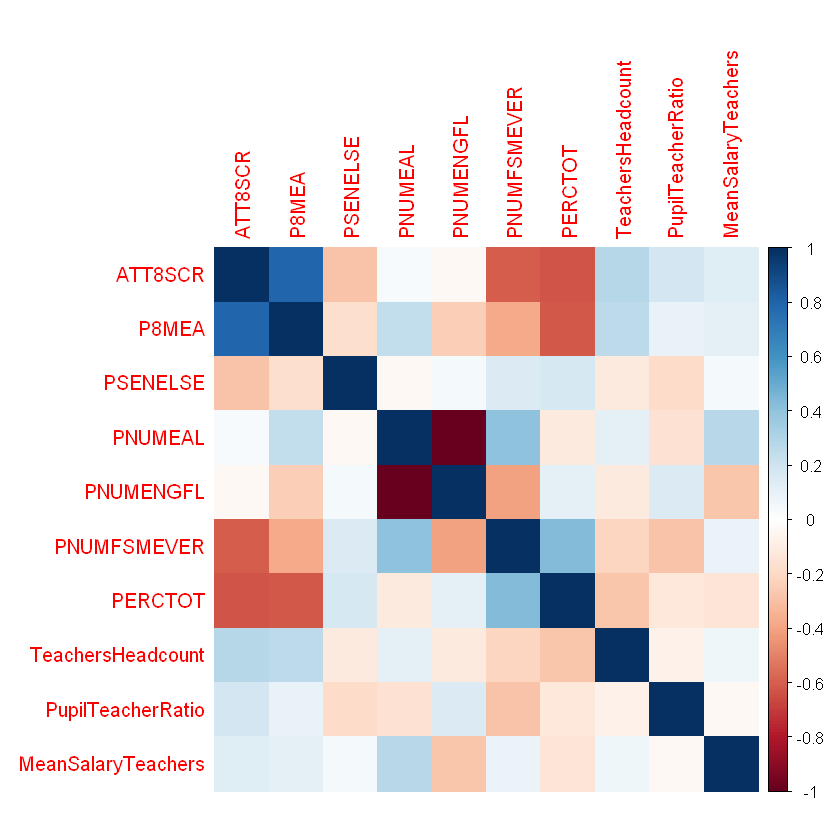

In [26]:
#colcorr is a column to select fields for performing correlation analysis

# colcorr <- c('ATT8SCR', 'P8MEA', 'ATT8SCRFSM6CLA1A',
# 'P8MEAFSM6CLA1A', 'ATT8SCRNFSM6CLA1A', 'P8MEANFSM6CLA1A',
# 'ATT8SCRLO',
# 'P8MEALO',
# 'ATT8SCRAV',
# 'P8MEAAV',
# 'ATT8SCRHI',
# 'P8MEAHI',
# 'PSENELSE',
# 'PNUMEAL',
# 'PNUMENGFL',
# 'PNUMFSMEVER',
# 'PERCTOT',
# 'TeachersHeadcount',
# 'PupilTeacherRatio',
# 'MeanSalaryTeachers')

colcorr <- c('ATT8SCR', 'P8MEA',  
'PSENELSE',
'PNUMEAL',
'PNUMENGFL',
'PNUMFSMEVER',
'PERCTOT',
'TeachersHeadcount',
'PupilTeacherRatio',
'MeanSalaryTeachers')

CorrMatrix <- cor(merge_2018_19[, colcorr], use='complete.obs')
corrplot(CorrMatrix, method="color")

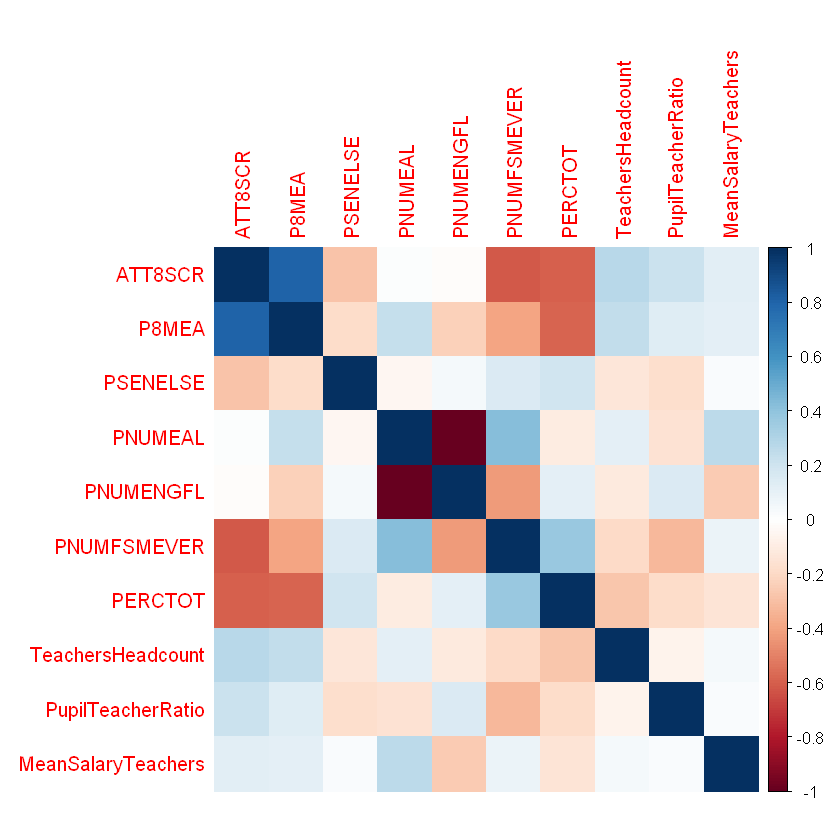

In [27]:
CorrMatrix <- cor(merge_2017_18[, colcorr], use='complete.obs')
corrplot(CorrMatrix, method="color")

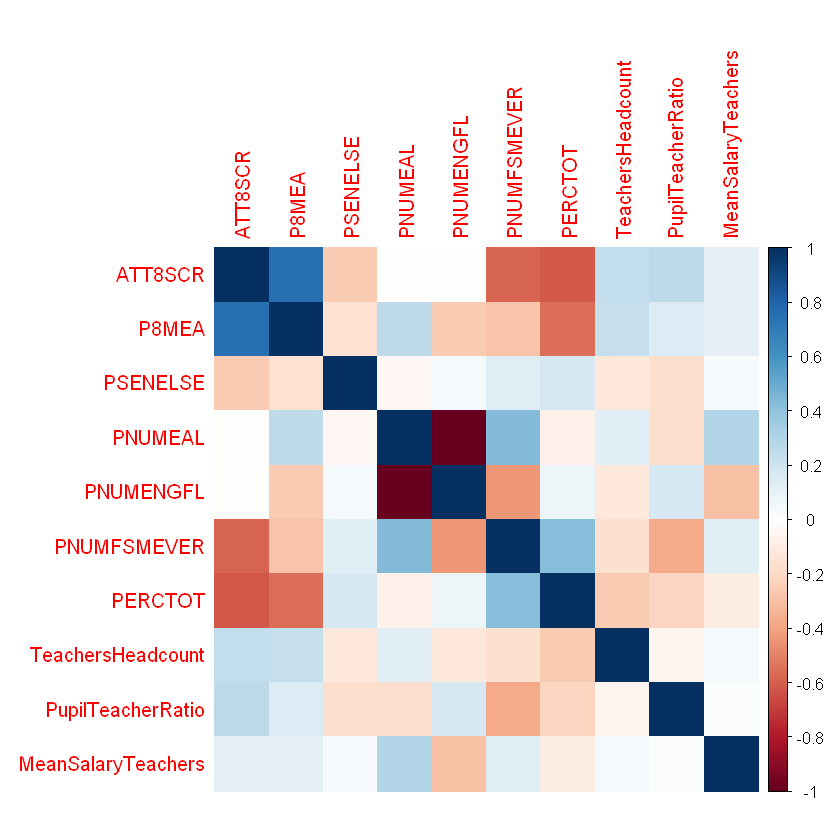

In [28]:
CorrMatrix <- cor(merge_2016_17[, colcorr], use='complete.obs')
corrplot(CorrMatrix, method="color")

Warning message:
"Removed 989 rows containing non-finite values (stat_boxplot)."
Warning message:
"Removed 989 rows containing non-finite values (stat_boxplot)."


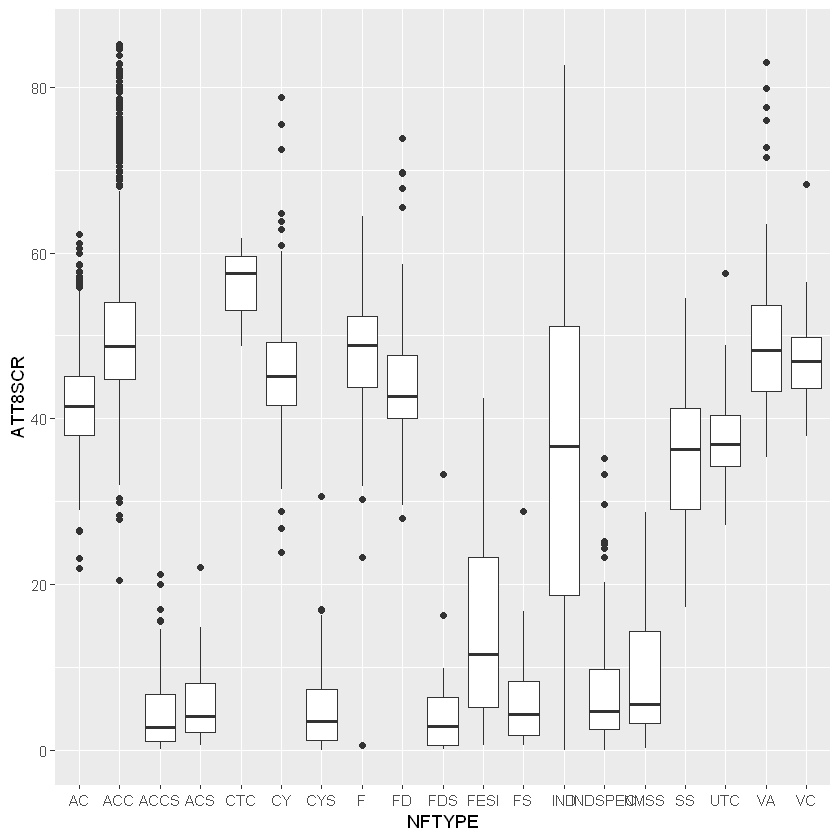

Warning message:
"Removed 989 rows containing non-finite values (stat_boxplot)."


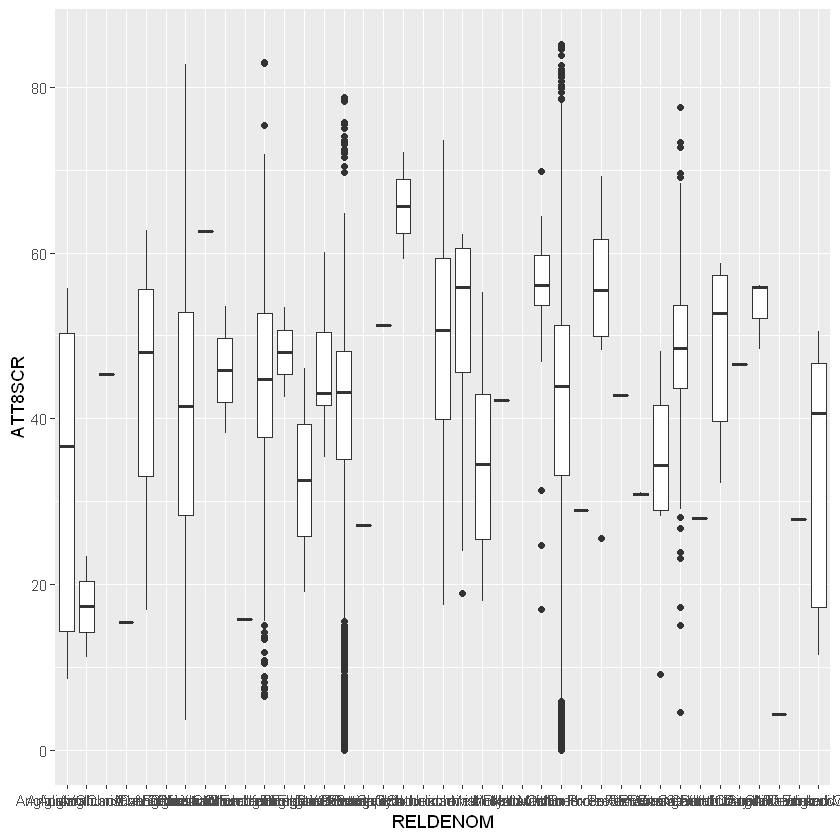

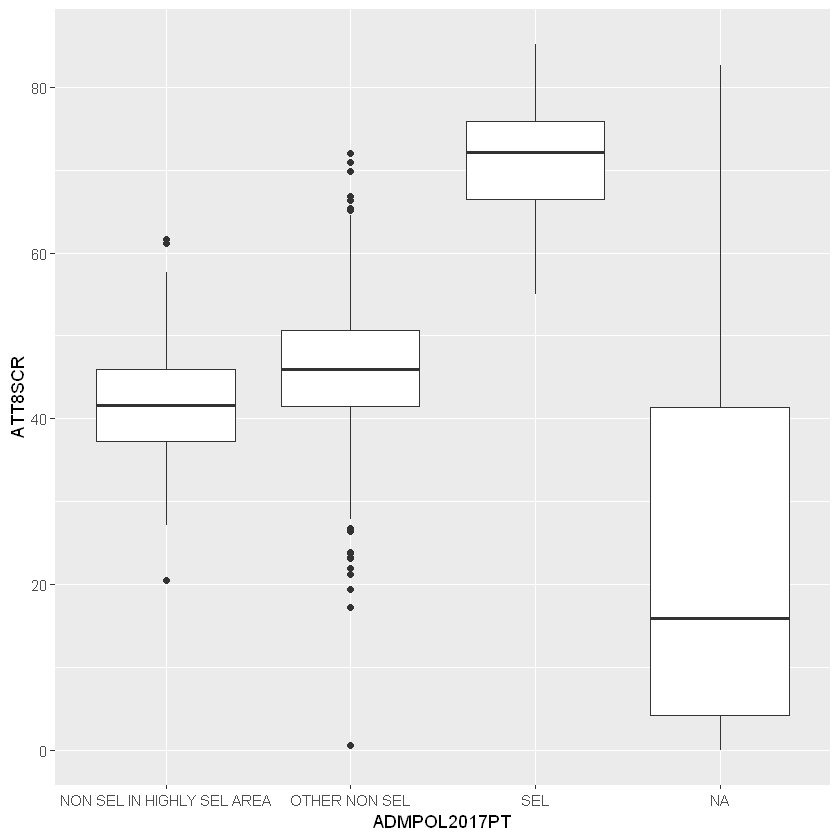

In [30]:
library(ggplot2)

#boxplot of ('NFTYPE', 'RELDENOM','ADMPOL2017PT') against ATT8SCR attainment8 score
qplot(data=merge_2018_19, x=NFTYPE, y=ATT8SCR, geom='boxplot')
qplot(data=merge_2018_19, x=RELDENOM, y=ATT8SCR, geom='boxplot')
qplot(data=merge_2018_19, x=ADMPOL2017PT, y=ATT8SCR, geom='boxplot')
# qplot(data=ks4ofstead_clean, x=OFSTEDRATING, y=P8MEA, geom='boxplot')

# 8. Possible Research Directions



- Derive or combine some relevant fields
- Add the Ofsted outstanding ranking dataset schoolinfo_2018_19 to study the relations
- Add school spending data which can be found in "england_cfrfull.csv" csv files
- Study differences in years, or taking average accross multiple years, e.g. avg(ATT8SCR) across three years 
- Study the effect of categorical variables ('NFTYPE', 'RELDENOM','ADMPOL2017PT') 
   * group differnt school types, religion types and admission policy types
- Perform regression or classification to build models



